In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

from astropy.time import Time
import astropy.units as u

import ssa_calc
# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)

Num GPUs Available:  1


In [2]:
# Loading the data
telem_path = r"../telemetry-files/delfi-pq/delfi-pq-telemetry-2022-01-18-to-2022-03-29.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)

# Adding illumination to the dataframe:
for i, row in telem_df.iterrows():
    telem_df.loc[i, "illumination"] = 1 if row["theta_T (deg)"] < 360 * (1 - row["fe"]) else 0

telem_df["illumination"] = telem_df["illumination"].astype(np.int64)
# Rearranging illumination column to be after theta_T (deg):
cols = telem_df.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
telem_df = telem_df[cols]
telem_df.head()

,time (utc),time (jd),beta (deg),fe,theta (deg),theta_T (deg),illumination,battery GG temperature (deg C),battery TMP20 temperature (deg C),solar panel Yp temperature (deg C),solar panel Ym temperature (deg C),solar panel Xp temperature (deg C),solar panel Xm temperature (deg C),MCU temperature (deg C)
0,2022-01-18 17:12:17.000,2.459598e+06,32.895989,0.349273,220.506984,337.637846,0,-4.2,-3.2,-24.7,-26.4,-25.0,-23.4,-12.2
1,2022-01-18 18:41:24.000,2.459598e+06,32.900397,0.349014,197.714357,314.891798,0,-0.7,0.8,-18.5,-20.7,-18.6,-17.8,-7.4
2,2022-01-18 18:43:24.000,2.459598e+06,32.901143,0.349090,205.275916,322.439748,0,-1.9,0.0,-20.9,-22.7,-20.8,-19.9,-8.9
3,2022-01-18 18:44:24.000,2.459598e+06,32.901391,0.349131,209.056697,326.213181,0,-2.4,-0.2,-21.9,-23.8,-22.1,-20.9,-9.8
4,2022-01-18 18:45:24.000,2.459598e+06,32.901552,0.349173,212.837490,329.986271,0,-3.0,-1.3,-23.0,-24.9,-23.2,-21.9,-11.2


In [3]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

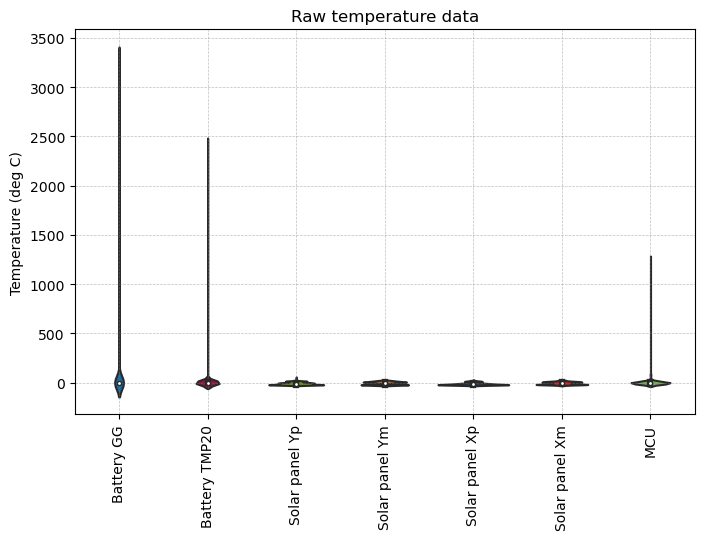

In [4]:
# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Raw temperature data")
ax.grid()
plt.show()

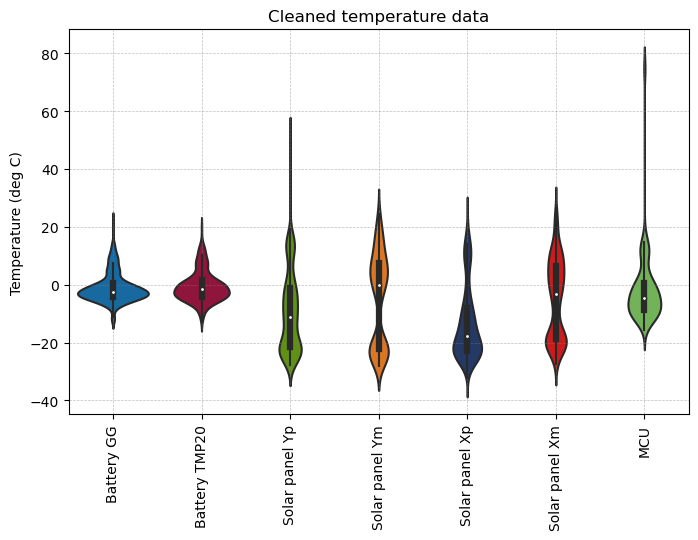

In [5]:
# Cleaning the data:
telem_processed_df = telem_df.copy()

for i, row in telem_processed_df.iterrows():
    # Removing temperature if > 200 deg C:
    for j, temp in row.iloc[6:].items():
        if temp > 200:
            telem_processed_df.loc[i, j] = np.nan

telem_processed_df = telem_processed_df.dropna(how="all").reset_index(drop=True)

# Plotting the temperature data in a violin plot:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.violinplot(
    data=telem_processed_df.loc[:, "battery GG temperature (deg C)":"MCU temperature (deg C)"],
    palette=plt_colors,
    ax=ax,
)
ax.set_xticklabels(
    [
        "Battery GG",
        "Battery TMP20",
        "Solar panel Yp",
        "Solar panel Ym",
        "Solar panel Xp",
        "Solar panel Xm",
        "MCU",
    ],
    rotation=90,
    ha="center",
)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Cleaned temperature data")
ax.grid()
plt.show()


In [6]:
def plot_model(theta_T_vals, temp_vals, plt_titles=None, labels=None, colors=None, plt_scatter=None, linestyles=None, limits=None):
    """
    Function to plot the temperatures vs. theta_T.
    :param theta_T_vals: theta_T values.
    :param temp_vals: Temperature values.
    :param plt_titles: Titles of the plots.
    :param labels: Labels of the plots.
    :param colors: Colors of the plots.
    :param plt_scatter: Whether to plot the data as a scatter plot or not.
    :param linestyles: Linestyles of the plots.
    :param limits: Limits of the temperature data.

    :return: None
    """
    plt_rows = 2
    plt_cols = 3
    
    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )
            
            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend()
            if limits is not None:
                ax[i, j].set_ylim(limits)
            ax[i, j].grid()

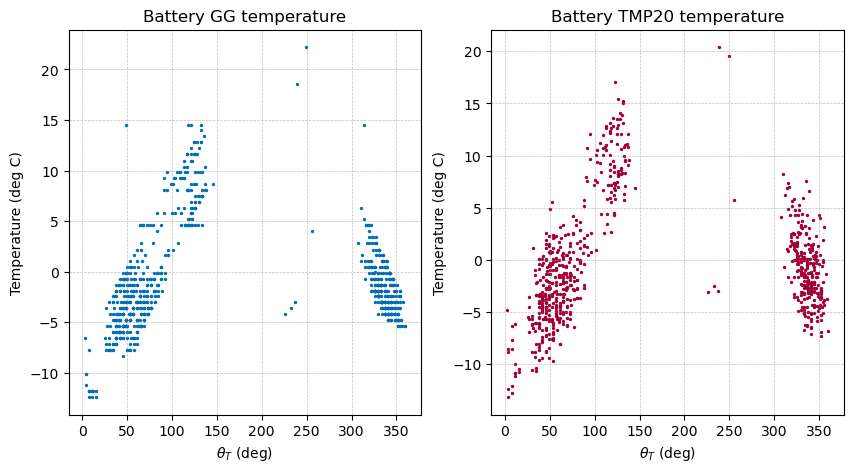

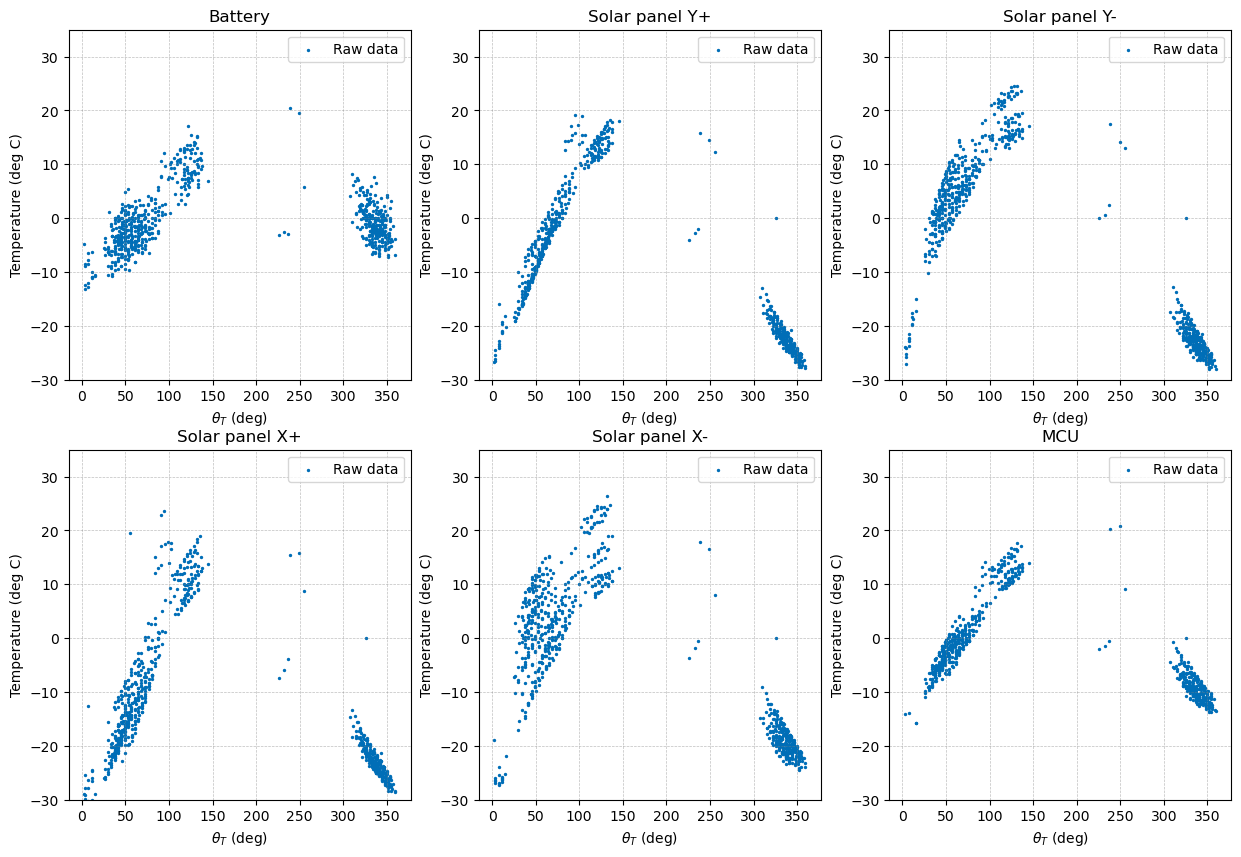

In [7]:
# Comparing the two battery temperatures (GG and TMP20):
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    telem_processed_df["theta_T (deg)"],
    telem_processed_df["battery GG temperature (deg C)"],
    label="GG",
    color=plt_colors[0],
    s=2,
)
ax[0].set_title("Battery GG temperature")

ax[1].scatter(
    telem_processed_df["theta_T (deg)"],
    telem_processed_df["battery TMP20 temperature (deg C)"],
    label="TMP20",
    color=plt_colors[1],
    s=2,
)
ax[1].set_title("Battery TMP20 temperature")

for i in range(2):
    ax[i].set_xlabel(r"$\theta_T$ (deg)")
    ax[i].set_ylabel("Temperature (deg C)")
    ax[i].grid()


# Plotting the temperature data vs. theta_T:
theta_T_vals = telem_processed_df["theta_T (deg)"].to_numpy()
temp_vals = telem_processed_df.loc[:, "battery TMP20 temperature (deg C)":"MCU temperature (deg C)"].to_numpy()

plot_model(
    [theta_T_vals],
    [temp_vals],
    plt_titles=[
        "Battery",
        "Solar panel Y+",
        "Solar panel Y-",
        "Solar panel X+",
        "Solar panel X-",
        "MCU",
    ],
    labels=["Raw data"],
    colors=[plt_colors[0]],
    plt_scatter=[True],
    limits=[-30, 35],
    
)

In [8]:
# Splitting the data into training and testing sets
train_df = telem_processed_df[:int(0.8 * len(telem_processed_df))].copy()
test_df = telem_processed_df[int(
    0.8 * len(telem_processed_df)):].copy().reset_index(drop=True)

# Normalizing the data
norm_limits = np.array([np.nanmin(train_df.iloc[:, 8:].to_numpy()), np.nanmax(train_df.iloc[:, 8:].to_numpy())])  # limits of the temperature data calculated only from the training data

train_norm_df = train_df.copy() # copying the training data to a new dataframe
test_norm_df = test_df.copy()   # copying the testing data to a new dataframe

train_norm_df.iloc[:, 8:] = normalize_temperature(train_norm_df.iloc[:, 8:].to_numpy(), norm_limits) # normalizing the training data
test_norm_df.iloc[:, 8:] = normalize_temperature(test_norm_df.iloc[:, 8:].to_numpy(), norm_limits)  # normalizing the testing data


In [9]:
def window_data_base(df, window_size, satellite, return_numpy=True):
    """
    Function to create windowed data for the base model.
    :param df: Dataframe to be windowed.
    :param window_size: Size of the window.
    :param return_numpy: Boolean to return the input and output numpy arrays of the model.
    :param check_continuity: Boolean to check for continuity in the data.

    :return: Windowed dataframe (and) numpy arrays of the input and output data.
    """


    columns = np.concatenate((
        ["time (jd)"],
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["battery temp"],
        ["solar panel Yp temp"],
        ["solar panel Ym temp"],
        ["solar panel Xp temp"],
        ["solar panel Xm temp"],
        ["MCU temp"],
    ))  # columns of the windowed dataframe

    window_df = pd.DataFrame(
        columns=columns, index=range(len(df)))
    with alive_bar(len(df), theme="classic", title="Windowing data", force_tty=True) as bar:
        for i in range(len(window_df)):
            window_df.iloc[i, 0] = df["time (jd)"][i]  # time value of the output
            window_df.iloc[i, 1] = df["theta_T (deg)"][i] # theta_T value of the output
            # Calculating the illumination values
            time = Time(df["time (utc)"][i])
            for j in range(window_size, 0, -1):
                beta, fe, theta, theta_T = satellite.calc_beta_fe_theta(time - j * u.min)
                window_df.iloc[i, window_size - j + 2] = 1 if theta_T < 2 * np.pi * (1 - fe) * u.rad else 0
            window_df.iloc[i, window_size + 2:] = df.iloc[i, 8:]  # temperature values of the output 
            bar()

    window_df = window_df.dropna().reset_index(drop=True)  # dropping the rows with NaN values


    if return_numpy:
        # Creating the numpy arrays
        x_data = np.empty(
            shape=(len(window_df), window_size, 1), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 6), dtype=np.float64)

        for i, row in window_df.iterrows():
            x_data[i, :, 0] = row.iloc[2:window_size + 2]   # input illumination values
            y_data[i, :] = row.iloc[window_size + 2:]   # output temperature values (normalized)

        return window_df, x_data, y_data

    return window_df

In [10]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(5, 5))
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")




In [11]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """

        # Train the model
        with tf.device(self.run_device):
            self.history = self.model.fit(
                self.train_x,
                self.train_y,
                epochs=epochs,
                validation_data=(self.test_x, self.test_y),
                callbacks=[callbacks],
            )

        # Plot the training history
        plt.figure(figsize=(5, 5))
        plt.plot(
            np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
            self.history.history["loss"],
            color=plt_colors[0],
            label="Training Loss",
        )
        plt.plot(
            np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
            self.history.history["val_loss"],
            color=plt_colors[1],
            label="Validation Loss",
        )
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(self.name)
        plt.legend()
        plt.grid()
        plt.show()

In [12]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

In [13]:
# Creating the Satellite object
POS_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-pos-interpolator-2022-01-18-to-2022-10-23.pkl"
VEL_INTERP_PATH = r"../orbit-propagation/interpolators/delfi-pq-vel-interpolator-2022-01-18-to-2022-10-23.pkl"
delfi_pq = ssa_calc.Satellite(POS_INTERP_PATH, VEL_INTERP_PATH)

Loading interpolators from pickle files...
Interpolators loaded.


In [14]:

# # Windowing the data
# print("Training data:")
# base_train_df, base_train_x, base_train_y = window_data_base(train_norm_df, 97, delfi_pq)   # create the training data for the base model
# print("Testing data:")
# base_test_df, base_test_x, base_test_y = window_data_base(test_norm_df, 97, delfi_pq) # create the testing data for the base model

# # Cleaning the data
# for i, row in base_train_df.iterrows():
#     if 200 < row.iloc[1] < 300:
#         base_train_df.loc[i, :] = np.nan
#         continue
#     for temp in row.iloc[-6:].values:
#         if temp > normalize_temperature(50, norm_limits):
#             base_train_df.loc[i, :] = np.nan
#             break

# base_train_df = base_train_df.dropna()
# base_train_x = base_train_x[base_train_df.index]
# base_train_y = base_train_y[base_train_df.index]

# for i, row in base_test_df.iterrows():
#     if 200 < row.iloc[1] < 300:
#         base_test_df.loc[i, :] = np.nan
#         continue
#     for temp in row.iloc[-6:].values:
#         if temp > normalize_temperature(50, norm_limits):
#             base_test_df.loc[i, :] = np.nan
#             break

# base_test_df = base_test_df.dropna()
# base_test_x = base_test_x[base_test_df.index]
# base_test_y = base_test_y[base_test_df.index]

# # Saving the training and testing data
# # Converting the datatypes of all columns to np.float64
# base_train_df = base_train_df.astype(np.float64).reset_index(drop=True)
# base_test_df = base_test_df.astype(np.float64).reset_index(drop=True)

# base_train_df.to_hdf("base-df.h5", key="train", mode="w")
# base_test_df.to_hdf("base-df.h5", key="test", mode="a")


In [15]:
# Loading the training and testing data
base_train_df = pd.read_hdf("base-df.h5", key="train")
base_test_df = pd.read_hdf("base-df.h5", key="test")

base_train_x = np.empty(shape=(len(base_train_df), 97, 1), dtype=np.float64)
base_train_y = np.empty(shape=(len(base_train_df), 6), dtype=np.float64)

for i, row in base_train_df.iterrows():
    base_train_x[i, :, 0] = row.iloc[2:99]   # input illumination values
    base_train_y[i, :] = row.iloc[99:]   # output temperature values (normalized)

base_test_x = np.empty(shape=(len(base_test_df), 97, 1), dtype=np.float64)
base_test_y = np.empty(shape=(len(base_test_df), 6), dtype=np.float64)

for i, row in base_test_df.iterrows():
    base_test_x[i, :, 0] = row.iloc[2:99]   # input illumination values
    base_test_y[i, :] = row.iloc[99:]   # output temperature values (normalized)

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         264192    
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, 16)                3

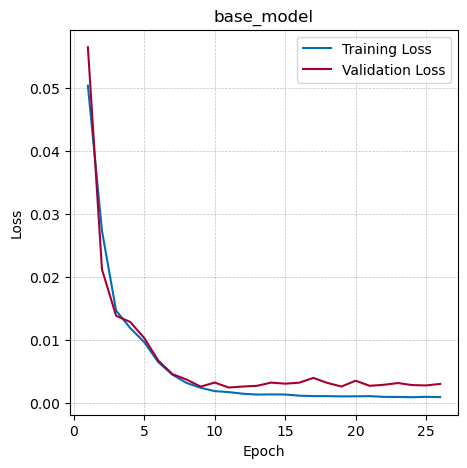

In [16]:
base_model = Model(
    base_train_x,
    base_train_y,
    base_test_x,
    base_test_y,
    name="base_model",
)   # initialize the base model

base_model.create_model(
    base_model_layers,
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    tf.keras.losses.MeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    input_shape=(None, 1),
    output_shape=6,
)   # create the base model

base_model.model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
)   # create an early stopping callback

base_model.train_model(250, early_stopping)   # train the base model

In [17]:
# Creating illumination data for a full orbit:
start_time = Time("2022-01-27 18:33:00", format="iso", scale="utc") - 97 * u.min

theta_T_list = []
illumination_list = []

with alive_bar(97+94, theme="classic", title="Creating illumination data", force_tty=True) as bar:
    for i in range(97+94):
        time = start_time + i * u.min
        beta, fe, theta, theta_T = delfi_pq.calc_beta_fe_theta(time)
        theta_T_list.append(theta_T.to(u.deg).value)
        illumination_list.append(1 if theta_T < 2 * np.pi * (1 - fe) * u.rad else 0)
        bar()

# Creating test x and y data for the base model
artificial_test_x = np.empty(shape=(94, 97, 1), dtype=np.float64)

for i in range(94):
    artificial_test_x[i, :, 0] = illumination_list[i:97+i]

artificial_test_y = base_model.model.predict(artificial_test_x)

Creating illumination data [========================================] 191/191 [100%] in 2.4s (78.66/s)                  
3/3 [==============================] - 6s 41ms/step


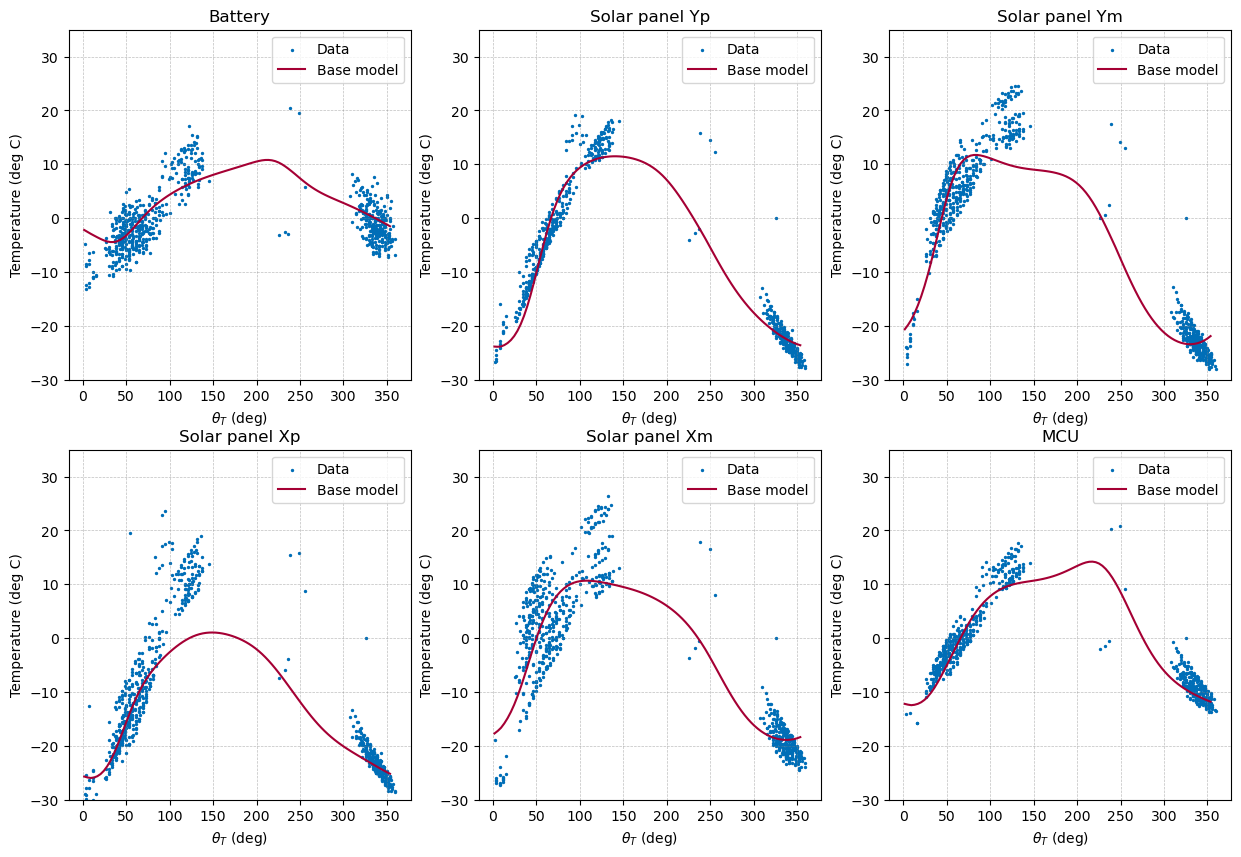

In [18]:
theta_T_vals = [telem_processed_df["theta_T (deg)"].to_numpy(), np.array(theta_T_list[97:])]
temp_vals = [telem_processed_df.iloc[:, 8:].to_numpy(), denormalize_temperature(artificial_test_y, norm_limits)]

# Plotting the temperature data
plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Data", "Base model"],
    colors=[plt_colors[0], plt_colors[1]],
    plt_scatter=[True, False],
    limits=[-30, 35]
)

In [19]:
def window_data_res(base_df, base_preds, base_window_size, res_window_size, return_numpy=True):
    """
    Function to create the data for the residual model.
    :param df: dataframe to create the data from
    :param base_window_size: window size of the base model (illumination data)
    :param res_window_size: window size of the residual model (temperature data)
    :param base_model: base model to use
    :param return_numpy: boolean to return input and output numpy arrays for the model
    :param check_continuity: boolean to check if the data is continuous

    :return: dataframe with the windowed data (and) input numpy array, output numpy array
    """

    # Columns of the residual model dataframe
    columns = np.concatenate((
        ["time (jd)"],
        ["theta_T"],
        ["illumination " + str(i) for i in range(base_window_size)],
        ["input battery temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Yp temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Ym temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Xp temp " + str(i) for i in range(res_window_size)],
        ["input solar panel Xm temp " + str(i) for i in range(res_window_size)],
        ["input MCU temp " + str(i) for i in range(res_window_size)],
        ["predicted battery temp"],
        ["predicted solar panel Yp temp"],
        ["predicted solar panel Ym temp"],
        ["predicted solar panel Xp temp"],
        ["predicted solar panel Xm temp"],
        ["predicted MCU temp"],
        ["output battery temp"],
        ["output solar panel Yp temp"],
        ["output solar panel Ym temp"],
        ["output solar panel Xp temp"],
        ["output solar panel Xm temp"],
        ["output MCU temp"],
    ))

    window_df = pd.DataFrame(columns=columns, index=range(len(base_df) - res_window_size))  # create the dataframe

    with alive_bar(len(window_df), theme="classic", title="Creating windowed data", force_tty=True) as bar:
        for i in range(len(window_df)):
            if base_df.loc[i + res_window_size, "time (jd)"] - base_df.loc[i, "time (jd)"] > res_window_size * 1.1 / 1440:
                bar()
                continue
            
            window_df.loc[i, "time (jd)"] = base_df.loc[i + res_window_size, "time (jd)"]
            window_df.loc[i, "theta_T"] = base_df.loc[i + res_window_size, "theta_T"]
            window_df.loc[i, "illumination 0":"illumination " + str(base_window_size - 1)] = base_df.loc[i + res_window_size, "illumination 0":"illumination " + str(base_window_size - 1)]
            window_df.loc[i, "input battery temp 0":"input battery temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "battery temp"].values
            window_df.loc[i, "input solar panel Yp temp 0":"input solar panel Yp temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Yp temp"].values
            window_df.loc[i, "input solar panel Ym temp 0":"input solar panel Ym temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Ym temp"].values
            window_df.loc[i, "input solar panel Xp temp 0":"input solar panel Xp temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Xp temp"].values
            window_df.loc[i, "input solar panel Xm temp 0":"input solar panel Xm temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "solar panel Xm temp"].values
            window_df.loc[i, "input MCU temp 0":"input MCU temp " + str(res_window_size - 1)] = base_df.loc[i:i + res_window_size - 1, "MCU temp"].values
            window_df.loc[i, "predicted battery temp":"predicted MCU temp"] = base_preds[i + res_window_size]
            window_df.loc[i, "output battery temp"] = base_df.loc[i + res_window_size, "battery temp"]
            window_df.loc[i, "output solar panel Yp temp"] = base_df.loc[i + res_window_size, "solar panel Yp temp"]
            window_df.loc[i, "output solar panel Ym temp"] = base_df.loc[i + res_window_size, "solar panel Ym temp"]
            window_df.loc[i, "output solar panel Xp temp"] = base_df.loc[i + res_window_size, "solar panel Xp temp"]
            window_df.loc[i, "output solar panel Xm temp"] = base_df.loc[i + res_window_size, "solar panel Xm temp"]
            window_df.loc[i, "output MCU temp"] = base_df.loc[i + res_window_size, "MCU temp"]

            bar()

    # Removing rows with all NaN values
    window_df = window_df.dropna(how="all").reset_index(drop=True)

    if return_numpy:
        # Create the input and output numpy arrays
        x_data = np.empty(shape=(len(window_df), 6 * res_window_size + 7), dtype=np.float64)
        y_data = np.empty(shape=(len(window_df), 6), dtype=np.float64)

        for i, row in window_df.iterrows():
            # Index of last illumination data:
            idx = 2 + base_window_size - 1
            x_data[i] = row.iloc[2 + base_window_size - 1:-6].to_numpy()
            y_data[i] = (row.iloc[-6:].to_numpy() - row.iloc[-12:-6].to_numpy()) * (norm_limits[1] - norm_limits[0]) # set the output data (actual - predicted) and denormalize it

        return window_df, x_data, y_data

In [20]:
# Calculating the residuals of the base model
base_train_preds = base_model.model.predict(base_train_x, verbose=0)
base_train_res = (base_train_y - base_train_preds) * (norm_limits[1] - norm_limits[0])

norm_limits_res = [np.min(base_train_res), np.max(base_train_res)]

In [21]:
# list of window sizes for the residual model
res_window_sizes = range(1, 6)

# list of residual models
res_models = []

# Residual model layers
res_model_layers = np.empty(shape=(7), dtype=dict,)
res_model_layers[0] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[1] = {
    "type": "Dense",
    "units": 256,
    "activation": "relu",
}
res_model_layers[2] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[3] = {
    "type": "Dense",
    "units": 128,
    "activation": "relu",
}
res_model_layers[4] = {
    "type": "Dense",
    "units": 64,
    "activation": "relu",
}
res_model_layers[5] = {
    "type": "Dense",
    "units": 32,
    "activation": "relu",
}
res_model_layers[6] = {
    "type": "Dense",
    "units": 16,
    "activation": "relu",
}

# Create the residual models
base_train_preds = base_model.model.predict(base_train_x, verbose=0)
base_test_preds = base_model.model.predict(base_test_x, verbose=0)
for res_window_size in res_window_sizes:
    res_train_df, res_train_x, res_train_y = window_data_res(base_train_df.reset_index(drop=True), base_train_preds, 97, res_window_size)    # get the training data
    res_train_y = normalize_temperature(res_train_y, norm_limits_res)    # normalize the output data
    res_test_df, res_test_x, res_test_y = window_data_res(base_test_df.reset_index(drop=True), base_test_preds, 97, res_window_size)    # get the testing data
    res_test_y = normalize_temperature(res_test_y, norm_limits_res)  # normalize the output data

    res_model = Model(
        res_train_x,
        res_train_y,
        res_test_x,
        res_test_y,
        name=f"res_model_{res_window_size}",
    )   # initialize the residual model

    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=7.5e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(6 * res_window_size + 7,),
        output_shape=6,
    )   # create the residual model

    res_models.append(res_model)    # add the residual model to the list

Creating windowed data [========================================] 585/585 [100%] in 1.5s (397.29/s)                     
Creating windowed data [========================================] 137/137 [100%] in 0.3s (537.83/s)                     
Creating windowed data [========================================] 584/584 [100%] in 0.9s (630.99/s)                     
Creating windowed data [========================================] 136/136 [100%] in 0.2s (960.50/s)                     
Creating windowed data [========================================] 583/583 [100%] in 0.9s (742.02/s)                     
Creating windowed data [========================================] 135/135 [100%] in 0.2s (1480.91/s)                    
Creating windowed data [========================================] 582/582 [100%] in 0.4s (1549.16/s)                    
Creating windowed data [========================================] 134/134 [100%] in 0.1s (3749.70/s)                    
Creating windowed data [========

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=250,
    restore_best_weights=True,
)   # early stopping callback

# Train all the residual models
for res_model in res_models:
    res_model.model.summary()
    res_model.train_model(5000, early_stopping)

Model: "res_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               3584      
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                

5/5 [==============================] - 0s 50ms/step


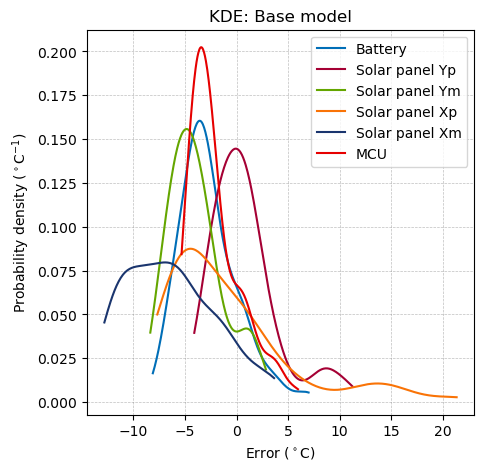

3/3 [==============================] - 0s 3ms/step


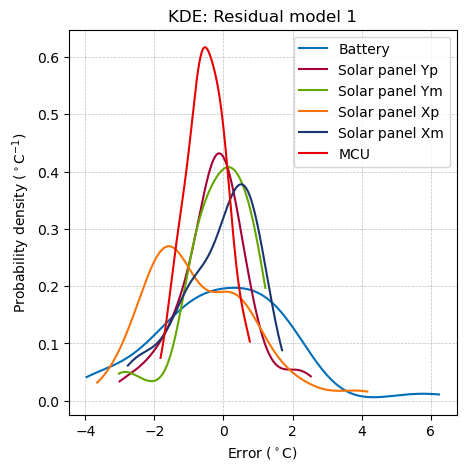

2/2 [==============================] - 0s 2ms/step


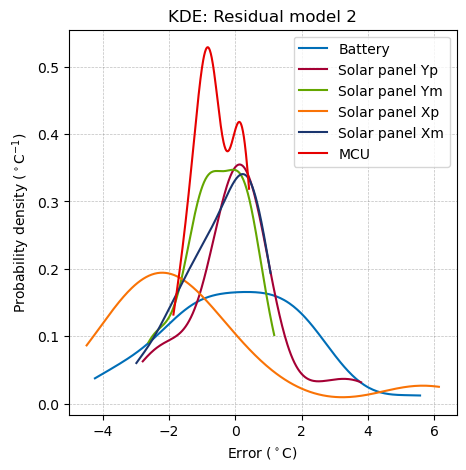

1/1 [==============================] - 0s 81ms/step


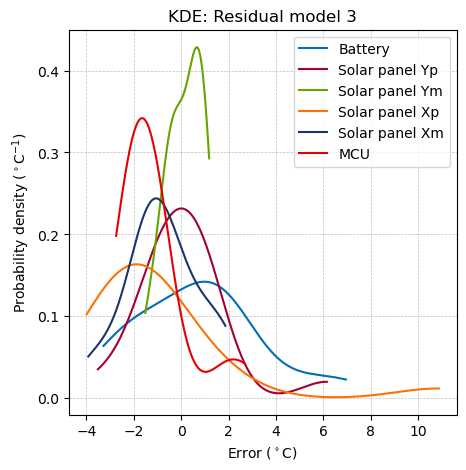

1/1 [==============================] - 0s 89ms/step


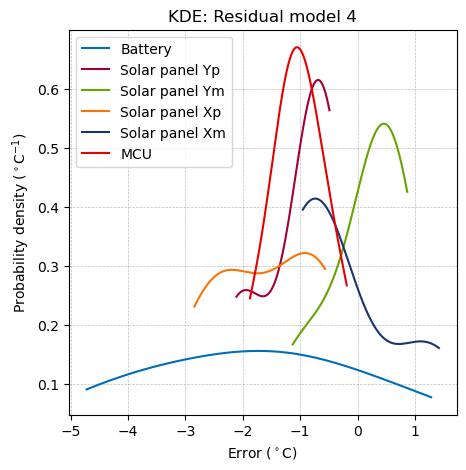

1/1 [==============================] - 0s 96ms/step


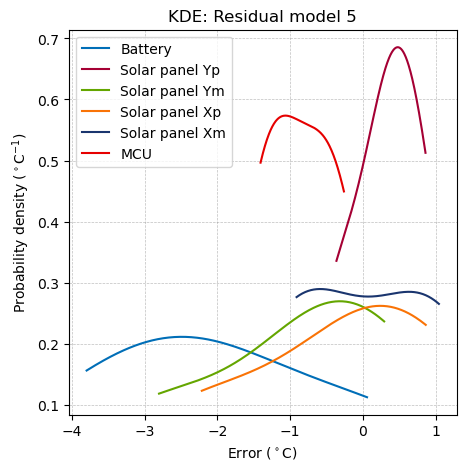

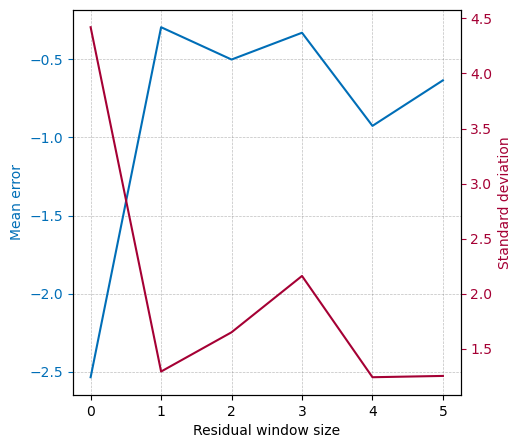

In [ ]:
# Evaluate the base and residual models:
mean_res = np.empty(shape=(len(res_window_sizes) + 1,), dtype=np.float64)
std_res = np.empty(shape=(len(res_window_sizes) + 1,), dtype=np.float64)

base_preds = base_model.model.predict(base_test_x, verbose=1)
base_errors = (base_test_y - base_preds) * (norm_limits[1] - norm_limits[0])
_ = kde(
    base_errors,
    labels=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    plt_title="KDE: Base model"
)
mean_res[0] = np.mean(base_errors)
std_res[0] = np.std(base_errors)

for i, res_model in enumerate(res_models):
    res_preds = res_model.model.predict(res_model.test_x, verbose=1)
    res_errors = (res_model.test_y - res_preds) * (norm_limits_res[1] - norm_limits_res[0])
    _ = kde(
        res_errors,
        labels=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
        plt_title=f"KDE: Residual model {i + 1}"
    )
    mean_res[i + 1] = np.mean(res_errors)
    std_res[i + 1] = np.std(res_errors)

step_sizes = np.concatenate(([0], res_window_sizes))

# Plot the mean_res prediction error and standard deviation of the combined model for different residual window sizes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax_twin = ax.twinx()
ax.plot(
    step_sizes,
    mean_res,
    color=plt_colors[0],
)
ax_twin.plot(
    step_sizes,
    std_res,
    color=plt_colors[1],
)
ax.set_xlabel("Residual window size")
ax.set_ylabel("Mean error", color=plt_colors[0])
ax_twin.set_ylabel("Standard deviation", color=plt_colors[1])
ax.grid()
ax.tick_params(axis="y", colors=plt_colors[0])
ax_twin.tick_params(axis="y", colors=plt_colors[1])

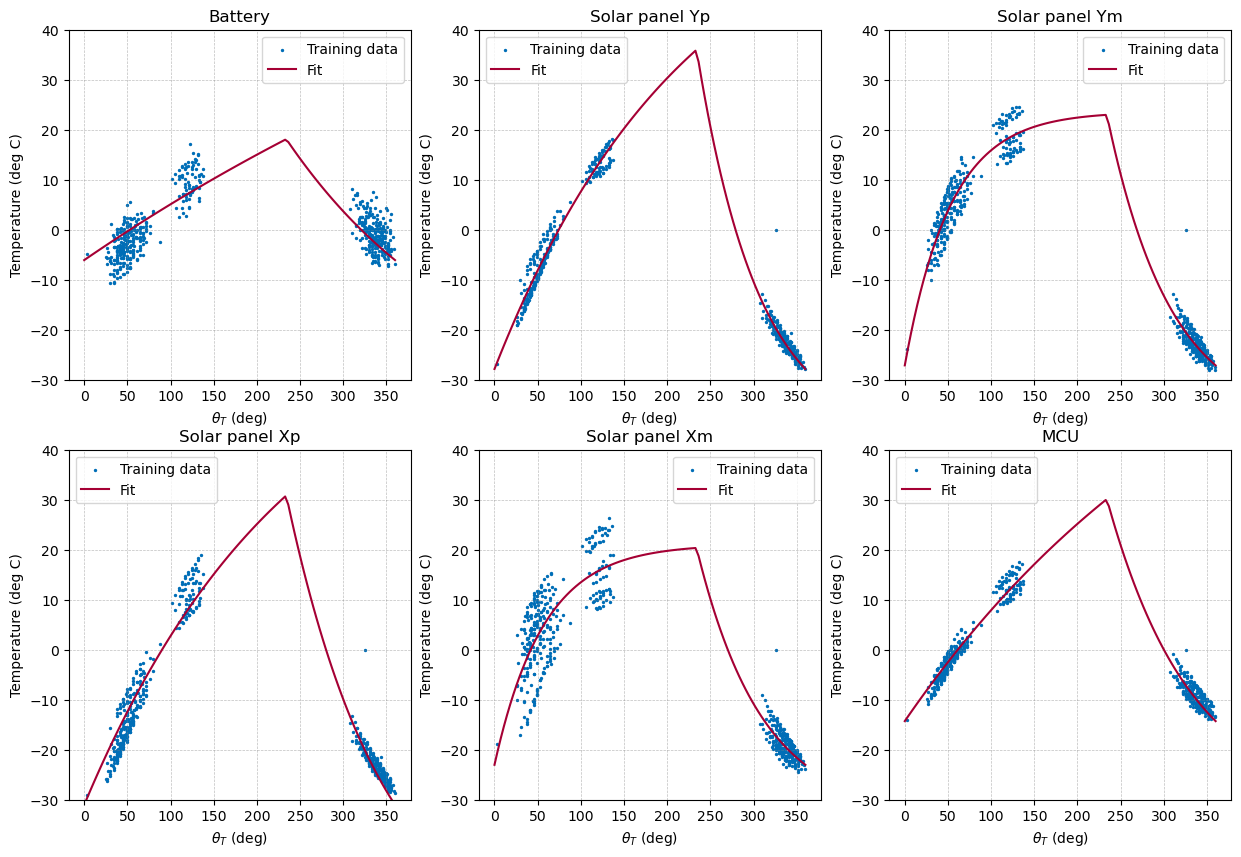

In [ ]:
# Curve fit 
# Exponential fit on the temperature data with the following conditions:
#   - The temperature at theta_T = 0 and theta_T = 360 is the same
#   - The temperature at the end of the heating phase is the same as the temperature at the beginning of the cooling phase

fe_mean = np.mean(telem_df["fe"])   # Mean fe for the data
theta_E = 360 * (1 - fe_mean)       # Mean theta_E for the data

def fit_function(theta_T, T_sat_rising, r_rising, T_0, dT_0_falling):
    """
    Function to fit to the temperature data.
    :param theta_T: Array of theta_T values
    :param T_sat_rising: Saturation temperature of the heating phase
    :param r_rising: Rate of temperature rise during heating phase
    :param T_0: Temperature at theta_T = 0
    :param dT_0_falling: delta T between T_0 and saturation temperature of cooling phase
    """
    T_E = T_sat_rising * (1 - np.exp(-r_rising * theta_E)) + T_0    # Temperature at the beginning of ecllipse

    T_sat_falling = T_0 - dT_0_falling  # Saturation cooling temperature at theta_T = inf

    # Determining rate of falling temperature to satisfy T_begin = T_end at theta_E = 0 and theta_E = 360
    r_falling = -np.log(dT_0_falling / (T_E - T_sat_falling)) / (360 - theta_E)

    return_array = np.empty(shape=theta_T.shape, dtype=np.float64)

    for i, theta_T_i in enumerate(theta_T):
        if theta_T_i < theta_E:
            return_array[i] = T_sat_rising * (1 - np.exp(-r_rising * theta_T_i)) + T_0
        else:
            return_array[i] = (T_E - T_sat_falling) * np.exp(-r_falling * (theta_T_i - theta_E)) + T_sat_falling

    return return_array


# Fitting all temperature data:
fit_params = pd.DataFrame(
    columns=["T_sat_rising", "r_rising", "T_0", "dT_0_falling"],
)


for i in range(6):
    theta_T_data = base_train_df["theta_T"].to_numpy(dtype=np.float64)
    temp_data = denormalize_temperature(base_train_df.iloc[:, -6+i].to_numpy(dtype=np.float64), norm_limits) + 273.15

    popt, pcov = curve_fit(
        fit_function,
        theta_T_data,
        temp_data,
        p0=[25, 0.01, 300, 10],
        bounds=([0, 0, 200, 10], [100, 1, 350, 30]),
    )

    fit_params.loc[i] = popt

fit_params_np = fit_params.to_numpy(dtype=np.float64)

theta_T_fit = np.linspace(0, 360, 100)
temp_fit = np.empty(shape=(100, 6), dtype=np.float64)

for i in range(6):
    temp_fit[:, i] = fit_function(theta_T_fit, *fit_params.iloc[i]) - 273.15


# Plotting the fit
theta_T_vals = [base_train_df["theta_T"].to_numpy(dtype=np.float64), theta_T_fit]
temp_vals = [
    denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(dtype=np.float64), norm_limits), 
    temp_fit
]

plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    labels=["Training data", "Fit"],
    colors=[plt_colors[0], plt_colors[1]],
    plt_scatter=[True, False],
    limits=[-30, 40],
)

In [ ]:
# Using the curve fit as the base model
def curve_fit_model(theta_T):
    """
    Model that uses the curve fit as the base model.
    :param theta_T: Array of theta_T values

    :return: Array of temperature values
    """
    temp = np.empty(shape=(theta_T.shape[0], 6), dtype=np.float64)

    for i in range(6):
        temp[:, i] = fit_function(theta_T, *fit_params.iloc[i]) - 273.15

    return temp

In [ ]:
# Curve fit residuals
curve_fit_res = denormalize_temperature(base_train_df.iloc[:, -6:].to_numpy(), norm_limits) - curve_fit_model(base_train_df["theta_T"].to_numpy())
norm_limits_res_curve_fit = [np.min(curve_fit_res), np.max(curve_fit_res)]

In [ ]:
# list of residual models
res_curve_fit_models = []

# Create the residual models
base_train_preds = normalize_temperature(curve_fit_model(base_train_df["theta_T"].to_numpy()), norm_limits)
base_test_preds = normalize_temperature(curve_fit_model(base_test_df["theta_T"].to_numpy()), norm_limits)
for res_window_size in res_window_sizes:
    res_train_df, res_train_x, res_train_y = window_data_res(base_train_df.reset_index(drop=True), base_train_preds, 97, res_window_size)    # get the training data
    res_train_y = normalize_temperature(res_train_y, norm_limits_res)    # normalize the output data
    res_test_df, res_test_x, res_test_y = window_data_res(base_test_df.reset_index(drop=True), base_test_preds, 97, res_window_size)    # get the testing data
    res_test_y = normalize_temperature(res_test_y, norm_limits_res)  # normalize the output data

    res_model = Model(
        res_train_x,
        res_train_y,
        res_test_x,
        res_test_y,
        name=f"res__curve_fit_model_{res_window_size}",
    )   # initialize the residual model

    res_model.create_model(
        res_model_layers,
        tf.keras.optimizers.Adam(learning_rate=7.5e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(6 * res_window_size + 7,),
        output_shape=6,
    )   # create the residual model

    res_curve_fit_models.append(res_model)    # add the residual model to the list

Creating windowed data [========================================] 585/585 [100%] in 1.3s (508.69/s)                     
Creating windowed data [========================================] 137/137 [100%] in 0.2s (699.47/s)                     
Creating windowed data [========================================] 584/584 [100%] in 0.8s (948.84/s)                     
Creating windowed data [========================================] 136/136 [100%] in 0.2s (1003.77/s)                    
Creating windowed data [========================================] 583/583 [100%] in 0.5s (1144.86/s)                    
Creating windowed data [========================================] 135/135 [100%] in 0.1s (1948.34/s)                    
Creating windowed data [========================================] 582/582 [100%] in 0.4s (1690.07/s)                    
Creating windowed data [========================================] 134/134 [100%] in 0.1s (4278.87/s)                    
Creating windowed data [========

Model: "res__curve_fit_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               3584      
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 16)     

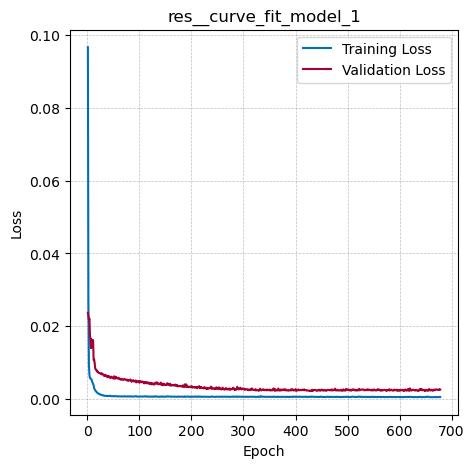

Model: "res__curve_fit_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 256)               5120      
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dense_52 (Dense)            (None, 128)               16512     
                                                                 
 dense_53 (Dense)            (None, 64)                8256      
                                                                 
 dense_54 (Dense)            (None, 32)                2080      
                                                                 
 dense_55 (Dense)            (None, 16)     

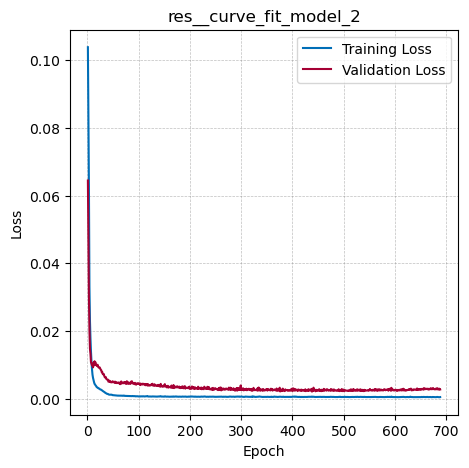

Model: "res__curve_fit_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 256)               6656      
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 dense_60 (Dense)            (None, 128)               16512     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 16)     

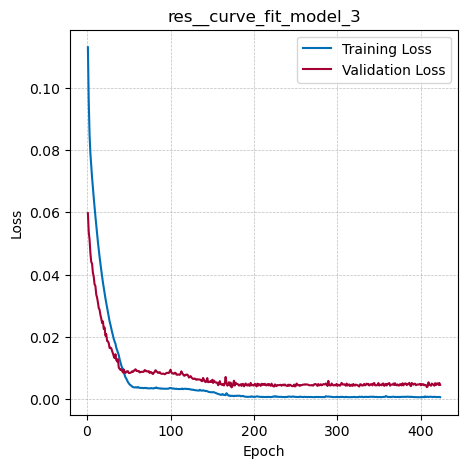

Model: "res__curve_fit_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 256)               8192      
                                                                 
 dense_66 (Dense)            (None, 256)               65792     
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dense_69 (Dense)            (None, 64)                8256      
                                                                 
 dense_70 (Dense)            (None, 32)                2080      
                                                                 
 dense_71 (Dense)            (None, 16)     

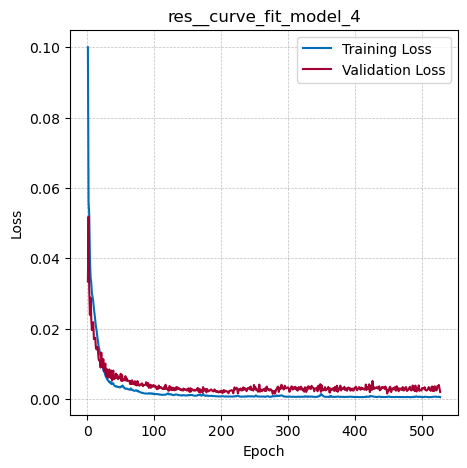

Model: "res__curve_fit_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 256)               9728      
                                                                 
 dense_74 (Dense)            (None, 256)               65792     
                                                                 
 dense_75 (Dense)            (None, 128)               32896     
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 16)     

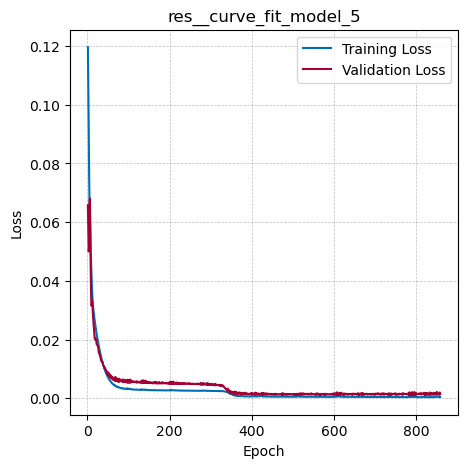

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=250,
    restore_best_weights=True,
)   # early stopping callback

# Train all the residual models
for res_model in res_curve_fit_models:
    res_model.model.summary()
    res_model.train_model(5000, early_stopping)

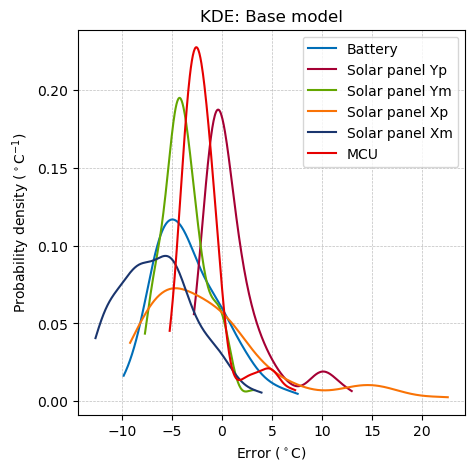

3/3 [==============================] - 0s 4ms/step


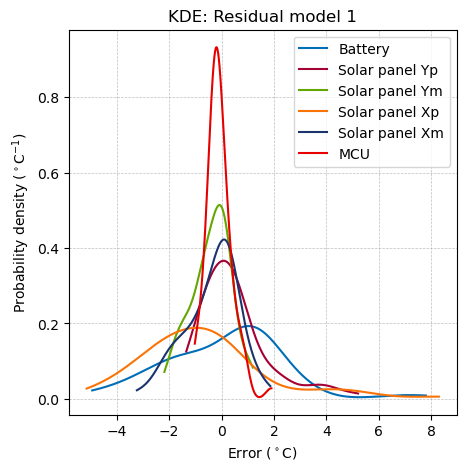

2/2 [==============================] - 0s 4ms/step


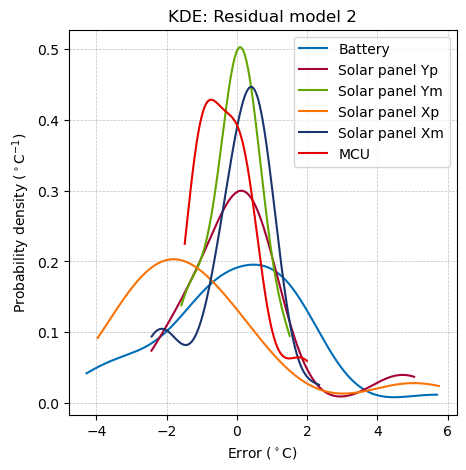

1/1 [==============================] - 0s 98ms/step


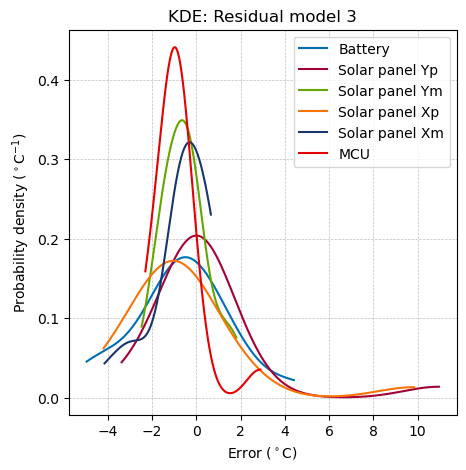

1/1 [==============================] - 0s 92ms/step


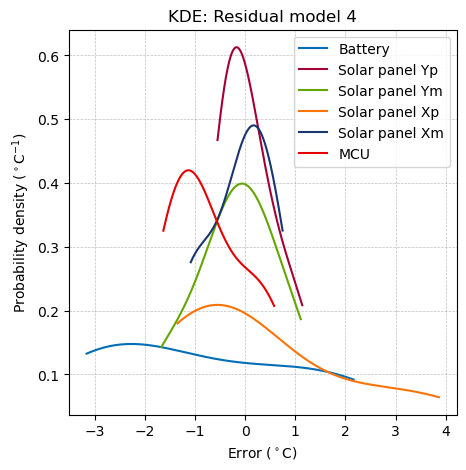

1/1 [==============================] - 0s 101ms/step


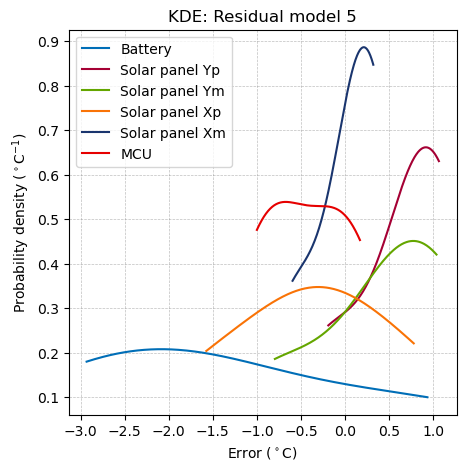

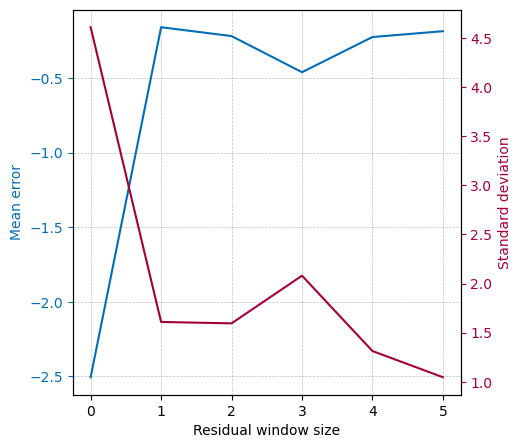

In [ ]:
# Evaluate the base and residual models:
mean_res_curve_fit = np.empty(shape=(len(res_window_sizes) + 1,), dtype=np.float64)
std_res_curve_fit = np.empty(shape=(len(res_window_sizes) + 1,), dtype=np.float64)

base_preds = normalize_temperature(curve_fit_model(base_test_df["theta_T"].to_numpy()), norm_limits)
base_errors = (base_test_y - base_preds) * (norm_limits[1] - norm_limits[0])
_ = kde(
    base_errors,
    labels=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
    plt_title="KDE: Base model"
)
mean_res_curve_fit[0] = np.mean(base_errors)
std_res_curve_fit[0] = np.std(base_errors)

for i, res_model in enumerate(res_curve_fit_models):
    res_preds = res_model.model.predict(res_model.test_x, verbose=1)
    res_errors = (res_model.test_y - res_preds) * (norm_limits_res[1] - norm_limits_res[0])
    _ = kde(
        res_errors,
        labels=["Battery", "Solar panel Yp", "Solar panel Ym", "Solar panel Xp", "Solar panel Xm", "MCU"],
        plt_title=f"KDE: Residual model {i + 1}"
    )
    mean_res_curve_fit[i + 1] = np.mean(res_errors)
    std_res_curve_fit[i + 1] = np.std(res_errors)

step_sizes = np.concatenate(([0], res_window_sizes))

# Plot the mean_res_curve_fit prediction error and standard deviation of the combined model for different residual window sizes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax_twin = ax.twinx()
ax.plot(
    step_sizes,
    mean_res_curve_fit,
    color=plt_colors[0],
)
ax_twin.plot(
    step_sizes,
    std_res_curve_fit,
    color=plt_colors[1],
)
ax.set_xlabel("Residual window size")
ax.set_ylabel("Mean error", color=plt_colors[0])
ax_twin.set_ylabel("Standard deviation", color=plt_colors[1])
ax.grid()
ax.tick_params(axis="y", colors=plt_colors[0])
ax_twin.tick_params(axis="y", colors=plt_colors[1])

In [1]:
import numpy as np
a = np.arange(1, 20)
print(a)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


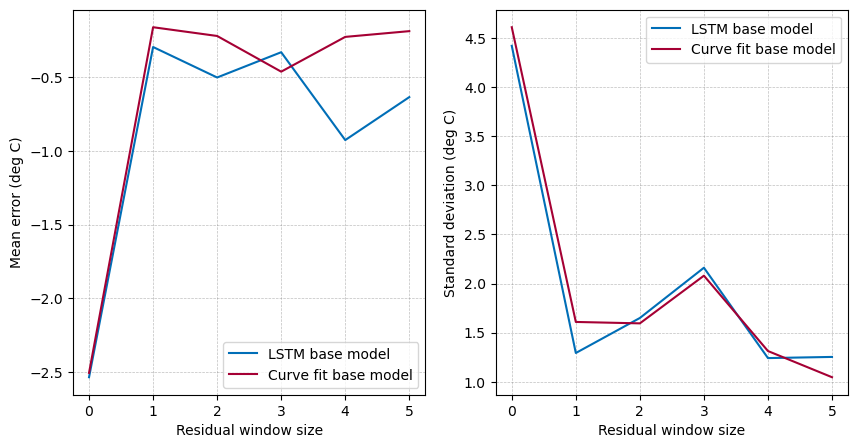

In [ ]:
# Comparing the effect of base models:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(
    step_sizes,
    mean_res,
    color=plt_colors[0],
    label="LSTM base model",
)
ax[0].plot(
    step_sizes,
    mean_res_curve_fit,
    color=plt_colors[1],
    label="Curve fit base model",
)
ax[0].set_xlabel("Residual window size")
ax[0].set_ylabel("Mean error (deg C)")
ax[0].grid()
ax[0].legend()

ax[1].plot(
    step_sizes,
    std_res,
    color=plt_colors[0],
    label="LSTM base model",
)
ax[1].plot(
    step_sizes,
    std_res_curve_fit,
    color=plt_colors[1],
    label="Curve fit base model",
)
ax[1].set_xlabel("Residual window size")
ax[1].set_ylabel("Standard deviation (deg C)")
ax[1].grid()
ax[1].legend()

plt.show()


In [ ]:
# Getting all the weights and biases of res_models[0]
res_model = res_models[0]
weights_list = np.array([], dtype=np.float32)
biases_list = np.array([], dtype=np.float32)

for layer in res_model.model.layers:

In [32]:
res_model = res_models[0]


In [34]:
print(res_model.model.layers[0].get_weights().shape)